In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv('./creditcard.csv')
card_df.head(3)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score
from sklearn.metrics import f1_score,confusion_matrix,precision_recall_curve,roc_curve

#인자로 입력받은 DataFrame을 복사한 뒤 Time column 삭제하고 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time',axis=1,inplace=True)
    return df_copy

#사전 데이터 가공 후 학습과 테스트 세트를 반환하는 함수
def get_train_test_dataset(df=None):
    df_copy = get_preprocessed_df(df)
    X_features = df_copy.iloc[:,:-1]
    y_target = df_copy.iloc[:,-1]
    #train_test_split(), stratify=y_target으로 Stratified 기반 분활
    X_train,X_test,y_train,y_test = \
    train_test_split(X_features,y_target,test_size=0.3,random_state=0,stratify=y_target)
    return X_train,X_test,y_train,y_test

def get_clf_eval(y_test,pred):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    auc = roc_auc_score(y_test,pred)
    print('confusion matrix')
    print(confusion)
    print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f}, f1: {3:.4f}, AUC: {4:.4f}'.format(accuracy,precision,recall,f1,auc))

def get_model_train_eval(model,ftr_train,ftr_test,tgt_train,tgt_test):
    model.fit(ftr_train,tgt_train)
    pred = model.predict(ftr_test)
    get_clf_eval(tgt_test,pred)
    

In [12]:
X_train,X_test,y_train,y_test = get_train_test_dataset(card_df)
print('train data label값 비율')
#shape은 row x column이니까 shape[0]은 row 개수
print(y_train.value_counts()/y_train.shape[0]*100)
print('test data label값 비율')
print(y_test.value_counts()/y_test.shape[0]*100)

train data label값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
test data label값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


In [19]:
#Logistic Regression와 LightGBM으로 예측 및 평가
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

lr_clf = LogisticRegression()
lr_clf.fit(X_train,y_train)
lr_pred = lr_clf.predict(X_test)
get_clf_eval(y_test,lr_pred)

lgbm_clf = LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1,boost_from_average=False)
get_model_train_eval(lgbm_clf,X_train,X_test,y_train,y_test)


confusion matrix
[[85282    13]
 [   58    90]]
accuracy: 0.9992, precision: 0.8738, recall: 0.6081, f1: 0.7171, AUC: 0.8040
confusion matrix
[[85289     6]
 [   36   112]]
accuracy: 0.9995, precision: 0.9492, recall: 0.7568, f1: 0.8421, AUC: 0.8783


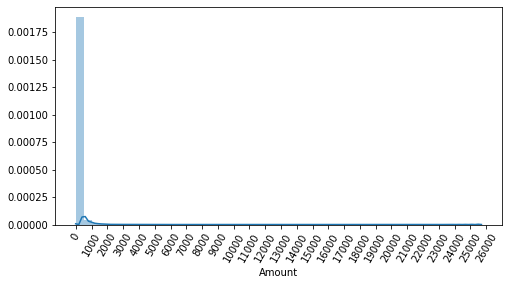

In [21]:
#Amount feature 분포도 확인
import seaborn as sns
plt.figure(figsize=(8,4))
plt.xticks(range(0,30000,1000),rotation=60)
sns.distplot(card_df['Amount'])


In [23]:
#StandardScalar 이용해 Amount feature를 정규 분포 형태로 변환
from sklearn.preprocessing import StandardScaler

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
    #변환된 Amount를 Amount_Scaled로 feature명 변경하고 DataFrame 맨 앞 column으로 입력
    df_copy.insert(0,'Amount_Scaled',amount_n)
    df_copy.drop(['Time','Amount'],axis=1,inplace=True)
    return df_copy

X_train,X_test,y_train,y_test = get_train_test_dataset(card_df)
print('LogisticRegression 예측 성능')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf,X_train,X_test,y_train,y_test)
print('LightGBM 예측 성능')
lgbm_clf = LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1,boost_from_average=False)
get_model_train_eval(lgbm_clf,X_train,X_test,y_train,y_test)


LogisticRegression 예측 성능
confusion matrix
[[85281    14]
 [   58    90]]
accuracy: 0.9992, precision: 0.8654, recall: 0.6081, f1: 0.7143, AUC: 0.8040
LightGBM 예측 성능
confusion matrix
[[85289     6]
 [   36   112]]
accuracy: 0.9995, precision: 0.9492, recall: 0.7568, f1: 0.8421, AUC: 0.8783


In [24]:
#StandardScaler 대신 로그 변환 수행

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    #log1p()를 이용해 Amount를 로그 변환
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0,'Amount_Scaled',amount_n)
    df_copy.drop(['Time','Amount'],axis=1,inplace=True)
    return df_copy

X_train,X_test,y_train,y_test = get_train_test_dataset(card_df)
print('LogisticRegression 예측 성능')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf,X_train,X_test,y_train,y_test)
print('LightGBM 예측 성능')
lgbm_clf = LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1,boost_from_average=False)
get_model_train_eval(lgbm_clf,X_train,X_test,y_train,y_test)


LogisticRegression 예측 성능
confusion matrix
[[85283    12]
 [   58    90]]
accuracy: 0.9992, precision: 0.8824, recall: 0.6081, f1: 0.7200, AUC: 0.8040
LightGBM 예측 성능
confusion matrix
[[85290     5]
 [   35   113]]
accuracy: 0.9995, precision: 0.9576, recall: 0.7635, f1: 0.8496, AUC: 0.8817


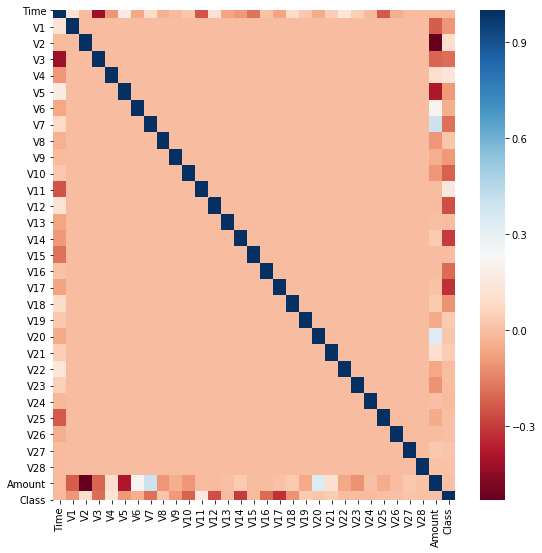

In [25]:
#IQR을 이용해 이상치 제거
import seaborn as sns

plt.figure(figsize=(9,9))
corr = card_df.corr()
sns.heatmap(corr,cmap='RdBu')


In [46]:
import numpy as np

def get_outlier(df=None,column=None,weight=1.5):
    #fraud에 해당하는 column 데이터만 추출, 1/4분위와 3/4분위 지점을 np.percentile로 구함
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values,25)
    quantile_75 = np.percentile(fraud.values,75)
    #IQR을 구하고 IQR에 1.5를 곱해 최댓값과 최솟값 지점 구함
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr*weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    #이상치 설정
    outlier_index = fraud[(fraud<lowest_val) | (fraud>highest_val)].index
    return outlier_index

outlier_index = get_outlier(df=card_df,column='V14',weight=1.5)
outlier_index2 = get_outlier(df=card_df,column='V17',weight=1.5)
print('이상치 index:',outlier_index)
print('이상치 index2:',outlier_index2)

이상치 index: Int64Index([8296, 8615, 9035, 9252], dtype='int64')
이상치 index2: Int64Index([], dtype='int64')


In [47]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    #log1p()를 이용해 Amount를 로그 변환
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0,'Amount_Scaled',amount_n)
    df_copy.drop(['Time','Amount'],axis=1,inplace=True)
    #이상치 데이터 삭제
    outlier_index = get_outlier(df=card_df,column='V14',weight=1.5)
    df_copy.drop(outlier_index,axis=0,inplace=True)
    return df_copy

X_train,X_test,y_train,y_test = get_train_test_dataset(card_df)
print('LogisticRegression 예측 성능')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf,X_train,X_test,y_train,y_test)
print('LightGBM 예측 성능')
lgbm_clf = LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1,boost_from_average=False)
get_model_train_eval(lgbm_clf,X_train,X_test,y_train,y_test)


LogisticRegression 예측 성능
confusion matrix
[[85282    13]
 [   48    98]]
accuracy: 0.9993, precision: 0.8829, recall: 0.6712, f1: 0.7626, AUC: 0.8355
LightGBM 예측 성능
confusion matrix
[[85291     4]
 [   25   121]]
accuracy: 0.9997, precision: 0.9680, recall: 0.8288, f1: 0.8930, AUC: 0.9144


In [49]:
#SMOTE 오버 샘플링 적용 후 모델 학습
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over,y_train_over = smote.fit_sample(X_train,y_train)
print('SMOTE 전 학습용 feature/label data set:',X_train.shape,y_train.shape)
print('SMOTE 후 학습용 feature/label data set:',X_train_over.shape,y_train_over.shape)
print('SMOTE 적용 후 label 값 분포:\n',pd.Series(y_train_over).value_counts())


SMOTE 전 학습용 feature/label data set: (199362, 29) (199362,)
SMOTE 후 학습용 feature/label data set: (398040, 29) (398040,)
SMOTE 적용 후 label 값 분포:
 1    199020
0    199020
dtype: int64


In [51]:
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf,X_train_over,X_test,y_train_over,y_test)


confusion matrix
[[82932  2363]
 [   11   135]]
accuracy: 0.9722, precision: 0.0540, recall: 0.9247, f1: 0.1021, AUC: 0.9485


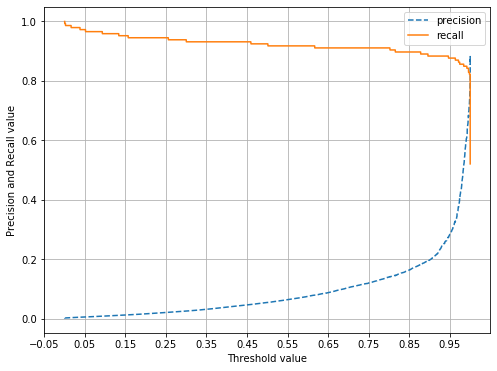

In [56]:
from sklearn.metrics import precision_recall_curve

def precision_recall_curve_plot(y_test,pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test,pred_proba_c1)
    
    #x축을 threshold값, y축은 정밀도, 재현율 값으로 plot, 정밀도는 점선
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds,precisions[0:threshold_boundary],linestyle='--',label='precision')
    plt.plot(thresholds,recalls[0:threshold_boundary],label='recall')
    
    #threshold 값 x축 scale을 0.1단위로 변경
    start,end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    
    #x축,y축 label과 legend, grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend();plt.grid()
    plt.show()

precision_recall_curve_plot(y_test,lr_clf.predict_proba(X_test)[:,1])


In [58]:
lgbm_clf = LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1,boost_from_average=False)
get_model_train_eval(lgbm_clf,X_train_over,X_test,y_train_over,y_test)


confusion matrix
[[85286     9]
 [   22   124]]
accuracy: 0.9996, precision: 0.9323, recall: 0.8493, f1: 0.8889, AUC: 0.9246


In [3]:
#Stacking
#개별 모델은 KNN,RandomForest,DecisionTree,AdaBoost, 최종 모델은 LogisticRegression
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_train,X_test,y_train,y_test = train_test_split(X_data,y_label,test_size=0.2,random_state=0)


In [4]:
knn_clf = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100,random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

knn_clf.fit(X_train,y_train)
rf_clf.fit(X_train,y_train)
dt_clf.fit(X_train,y_train)
ada_clf.fit(X_train,y_train)

knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test,knn_pred)))
print('RandomForest 정확도: {0:.4f}'.format(accuracy_score(y_test,rf_pred)))
print('DecisionTree 정확도: {0:.4f}'.format(accuracy_score(y_test,dt_pred)))
print('AdaBoost 정확도: {0:.4f}'.format(accuracy_score(y_test,ada_pred)))

pred = np.array([knn_pred,rf_pred,dt_pred,ada_pred])
print(pred.shape)
pred = np.transpose(pred)
print(pred.shape)

lr_final = LogisticRegression(C=10)
lr_final.fit(pred,y_test)
final = lr_final.predict(pred)
print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test,final)))


KNN 정확도: 0.9211
RandomForest 정확도: 0.9649
DecisionTree 정확도: 0.9035
AdaBoost 정확도: 0.9561
(4, 114)
(114, 4)
최종 메타 모델의 예측 정확도: 0.9737


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
